# Optimization benchmarking

Plotting benchmark result.

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

sys.path.append('../')
from qwopt.compiler import composer
from qwopt.benchmark import fidelity as fid

from numpy import pi
from qiskit import transpile
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit import Aer, execute
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import depolarizing_error
from tqdm import tqdm, trange
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.simplefilter('ignore')

## 1. Multi step of 4 node graph with one partition

## Target graph and probability transition matrix

In [2]:
alpha = 0.85
target_graph = np.array([[0, 1, 0, 1],
                                [0, 0, 1, 0],
                                [0, 1, 0, 1],
                                [0, 0, 1, 0]])

E = np.array([[1/4, 1/2, 0, 1/2],
                 [1/4, 0, 1/2, 0],
                 [1/4, 1/2, 0, 1/2],
                 [1/4, 0, 1/2, 0]])
# use google matrix
prob_dist = alpha*E + ((1-alpha)/4)*np.ones((4, 4))
init_state = 1/2*np.array([np.sqrt(prob_dist[j][i]) for i in range(4) for j in range(4)])

### Check points
- How to decrease the fidelity over the number of steps
- The number of operations

### Count operations

#### Without any optimizations

In [3]:
# Circuit
def four_node(opt, step):
    rotation = np.radians(31.788)
    cq = QuantumRegister(2, 'control')
    tq = QuantumRegister(2, 'target')
    c = ClassicalRegister(2, 'classical')
    if opt:
        anc = QuantumRegister(2, 'ancilla')
        qc = QuantumCircuit(cq, tq, anc, c)
    else:
        qc = QuantumCircuit(cq, tq, c)
        
#     initialize with probability distribution matrix
    initial = 1/2*np.array([np.sqrt(prob_dist[j][i]) for i in range(4) for j in range(4)])
    qc.initialize(initial, [*cq, *tq])
    
    for t in range(step):
        # Ti operation
        qc.x(cq[1])
        qc.ccx(cq[0], cq[1], tq[1])
        qc.x(cq[1])
        qc.barrier()

        # Kdg operation
        if opt:
            qc.x(cq)
            qc.rccx(cq[0], cq[1], anc[0])
            qc.barrier()

            qc.ch(anc[0], tq[0])
            qc.ch(anc[0], tq[1])
            
            qc.x(anc[0])
            qc.cry(-rotation, anc[0], tq[1])
            qc.ch(anc[0], tq[0])
            qc.barrier()
        else:
            qc.x(cq)
            qc.mcry(-pi/2, cq, tq[0], None)
            qc.mcry(-pi/2, cq, tq[1], None)
            qc.x(cq)
            qc.barrier()
            
            qc.x(cq[1])    
            qc.mcry(-pi/2, cq, tq[0], None)
            qc.mcry(-rotation, cq, tq[1], None)
            qc.x(cq[1])
            qc.barrier()
            
            qc.x(cq[0])    
            qc.mcry(-pi/2, cq, tq[0], None)
            qc.mcry(-rotation, cq, tq[1], None)
            qc.x(cq[0])
            qc.barrier()
            
            qc.mcry(-pi/2, cq, tq[0], None)
            qc.mcry(-rotation, cq, tq[1], None)
            qc.barrier()
            
        # D operation
        qc.x(tq)
        qc.cz(tq[0], tq[1])
        qc.x(tq)
        qc.barrier()

        # K operation
        if opt:
            qc.ch(anc[0], tq[0])
            qc.cry(rotation, anc[0], tq[1])
            qc.x(anc[0])
            qc.ch(anc[0], tq[1])
            qc.ch(anc[0], tq[0])
            
            qc.rccx(cq[0], cq[1], anc[0])
            qc.x(cq)
            qc.barrier()
        else:
            qc.mcry(pi/2, cq, tq[0], None)
            qc.mcry(rotation, cq, tq[1], None)
            qc.barrier()
            
            qc.x(cq[0])    
            qc.mcry(pi/2, cq, tq[0], None)
            qc.mcry(rotation, cq, tq[1], None)
            qc.x(cq[0])
            qc.barrier()
            
            qc.x(cq[1])    
            qc.mcry(pi/2, cq, tq[0], None)
            qc.mcry(rotation, cq, tq[1], None)
            qc.x(cq[1])
            qc.barrier()
            
            qc.x(cq)
            qc.mcry(pi/2, cq, tq[0], None)
            qc.mcry(pi/2, cq, tq[1], None)
            qc.x(cq)
            qc.barrier()

    # Tidg operation
        qc.x(cq[1])
        qc.ccx(cq[0], cq[1], tq[1])
        qc.x(cq[1])
        qc.barrier()

#             swap
        qc.swap(tq[0], cq[0])
        qc.swap(tq[1], cq[1])
    qc.measure(tq, c)
    return qc

{'11': 2020, '00': 2994, '10': 3061, '01': 1925}


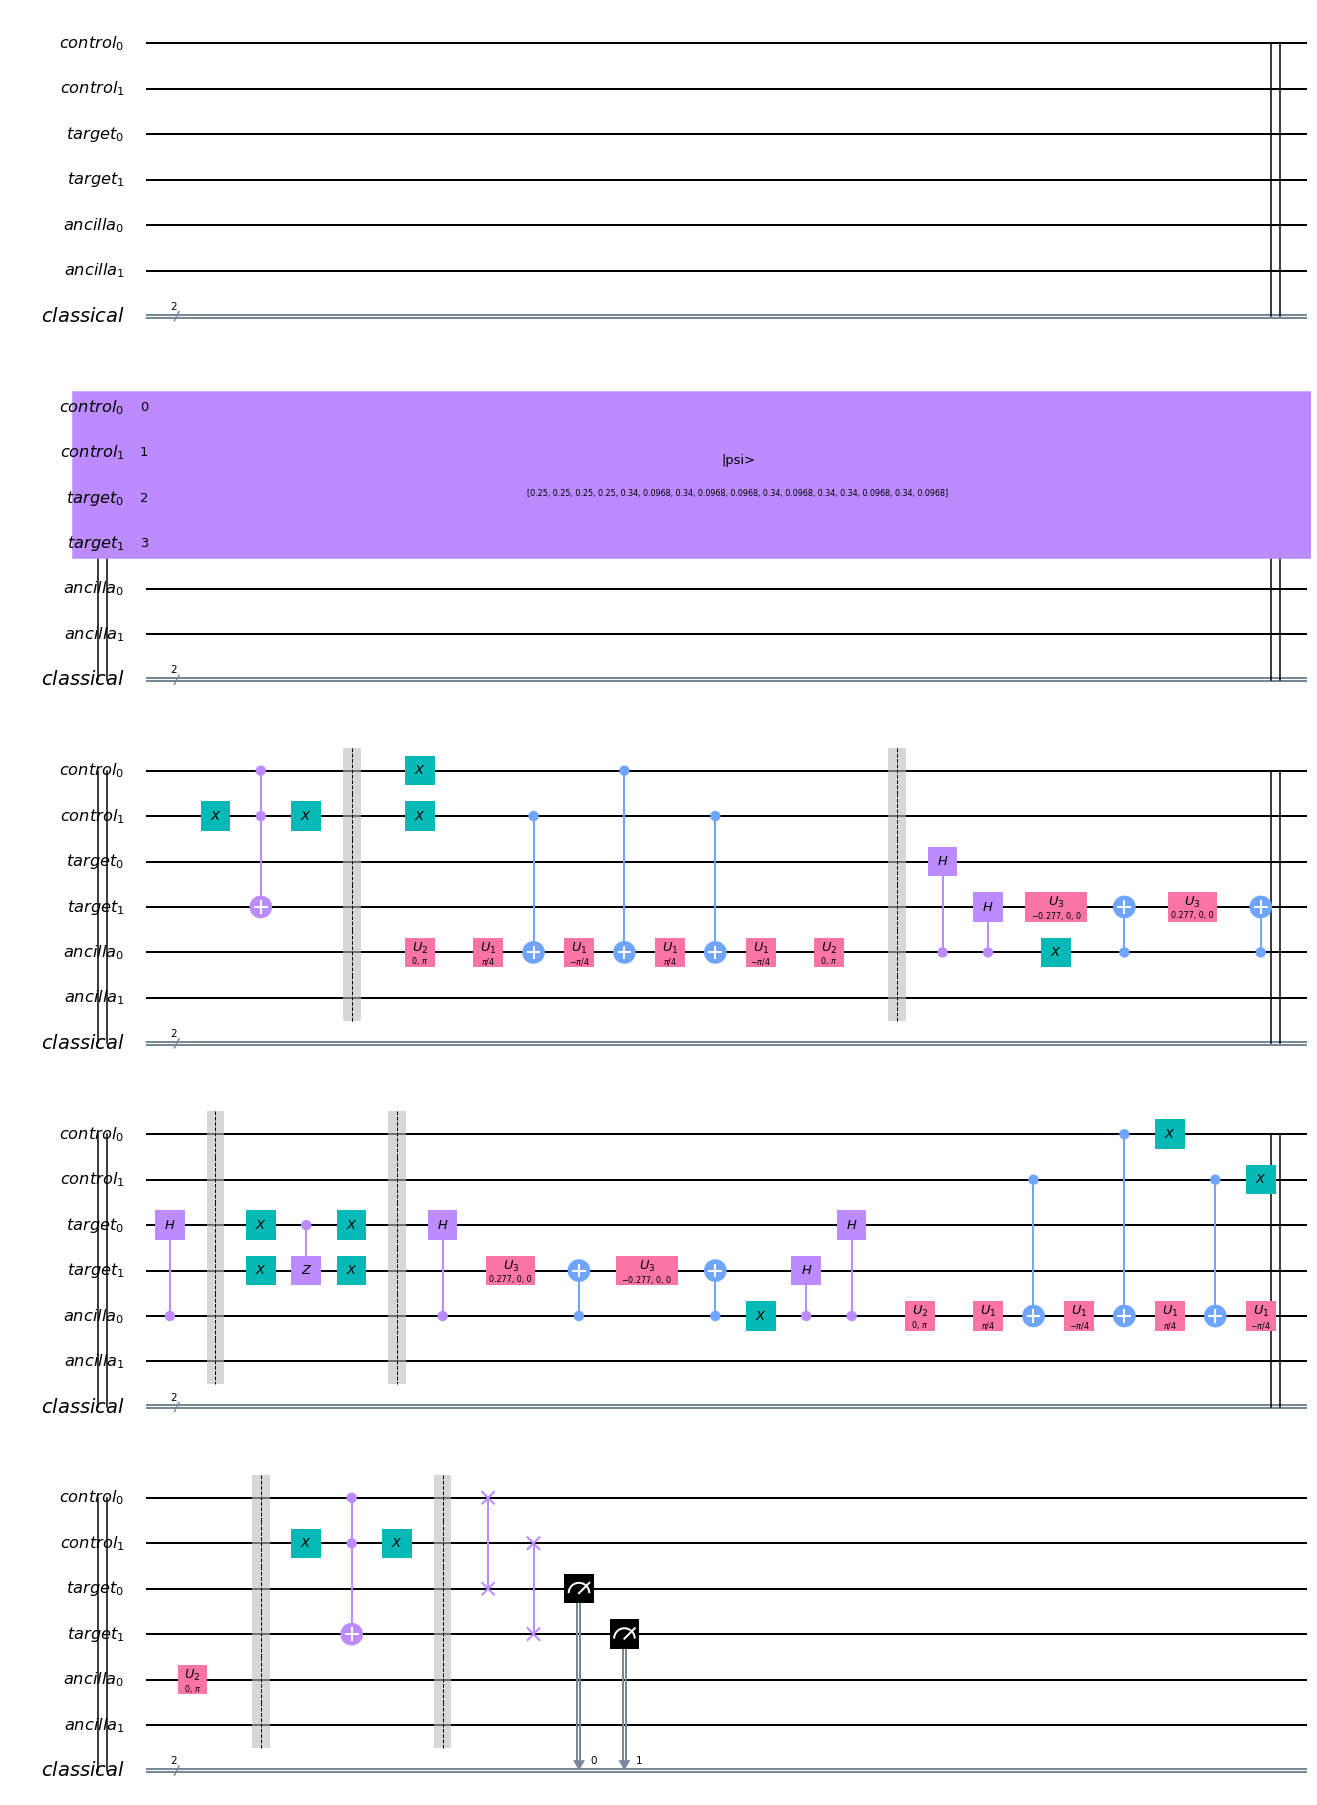

In [4]:
qc = four_node(True, 1)
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=10000)
count = job.result().get_counts(qc)
print(count)
qc.draw(output='mpl')

### The number of operations in steps

In [5]:
ex1_cx = []
ex1_u3 = []

ex2_cx = []
ex2_u3 = []

ex3_cx = []
ex3_u3 = []

ex4_cx = []
ex4_u3 = []

for step in trange(1, 11):
    opt_qc = transpile(four_node(True, step), basis_gates=['cx', 'u3'], optimization_level=0)
    ncx = opt_qc.count_ops().get('cx', 0)
    nu3 = opt_qc.count_ops().get('u3', 0) + opt_qc.count_ops().get('u2', 0) + opt_qc.count_ops().get('u1', 0)
    ex1_cx.append(ncx)
    ex1_u3.append(nu3)

#     ex2
    opt_qc = transpile(four_node(True, step), basis_gates=['cx', 'u3'], optimization_level=3)
    ncx = opt_qc.count_ops().get('cx', 0)
    nu3 = opt_qc.count_ops().get('u3', 0) + opt_qc.count_ops().get('u2', 0) + opt_qc.count_ops().get('u1', 0)
    ex2_cx.append(ncx)
    ex2_u3.append(nu3)
    
# ex3
    opt_qc = transpile(four_node(False, step), basis_gates=['cx', 'u3'], optimization_level=3)
    ncx = opt_qc.count_ops().get('cx', 0)
    nu3 = opt_qc.count_ops().get('u3', 0) + opt_qc.count_ops().get('u2', 0) + opt_qc.count_ops().get('u1', 0)
    ex3_cx.append(ncx)
    ex3_u3.append(nu3)

    #     ex4
    nopt_qc = transpile(four_node(False, step), basis_gates=['cx', 'u3'], optimization_level=0)
    ncx = nopt_qc.count_ops().get('cx', 0)
    nu3 = nopt_qc.count_ops().get('u3', 0) + nopt_qc.count_ops().get('u2', 0) + nopt_qc.count_ops().get('u1', 0)
    ex4_cx.append(ncx)
    ex4_u3.append(nu3)

100%|██████████| 10/10 [04:14<00:00, 25.46s/it]


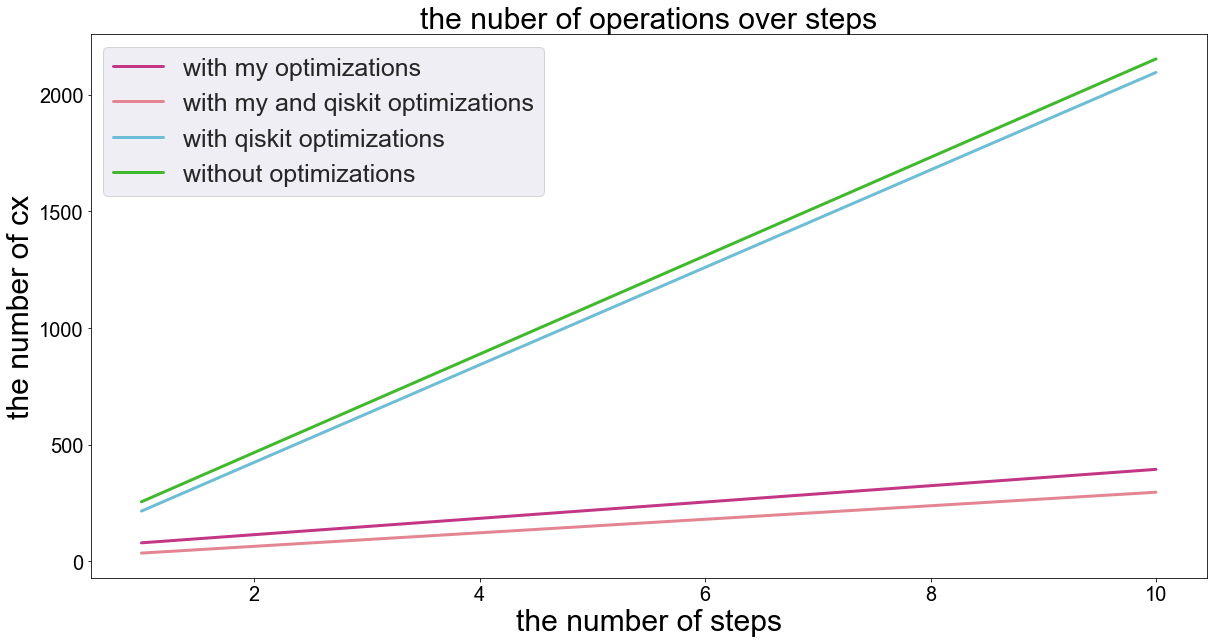

In [6]:
cx = [ex1_cx, ex2_cx, ex3_cx, ex4_cx]
u3 = [ex1_u3, ex2_cx, ex3_u3, ex4_u3]
color = ['#C23685',  '#E38692', '#6BBED5', '#3EBA2B']
labels = ['with my optimizations', 'with my and qiskit optimizations', 'with qiskit optimizations', 'without optimizations']
steps = range(1, 11)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
sns.set()
plt.xlabel('the number of steps', fontsize=30)
plt.ylabel('the number of cx', fontsize=30)
plt.title('the nuber of operations over steps', fontsize=30)
plt.tick_params(labelsize=20)
for cs, col, lab in zip(cx, color, labels):
    plt.plot(steps, cs, color=col, label=lab, linewidth=3)
plt.legend(fontsize=25)

## Error rate transition

In [7]:
import warnings
warnings.simplefilter('ignore')

In [2]:
qasm_sim = Aer.get_backend('qasm_simulator')

def KL_divergence(p, q, torelance=10e-9):
    '''
    p: np.array or list
    q: np.array or list
    '''
    parray = np.array(p) + torelance
    qarray = np.array(q) + torelance
    divergence = np.sum(parray*np.log(parray/qarray))
    return divergence

def get_error(qcs,  ideal, err_model, nq, type='KL', shots=5000):
    bins = [format(i, '0%db'%nq) for i in range(2**nq)]
    job = execute(qcs, backend=qasm_sim, shots=shots, noise_model=err_model)
    all_counts = [job.result().get_counts(qc) for qc in qcs]
    errors = []
    for counts in all_counts:
        prob = np.array([counts.get(b, 0)/shots for b in bins])
        id_prob = np.array(ideal)
#         l2_error = np.sum([(i-j)**2 for i, j in zip(id_prob, prob)])
        KL_error = KL_divergence(id_prob, prob)
        errors.append(KL_error)
    return KL_error

def theoretical_prob(initial, step, ptran, nq):
        Pi_op = Pi_operator(ptran)
        swap = swap_operator(nq)
        operator = (2*Pi_op) - np.identity(len(Pi_op))
        Szegedy = np.dot(operator, swap)
        Szegedy_n = copy.deepcopy(Szegedy)
        if step == 0:
            init_prob = np.array([abs(i)**2 for i in initial], dtype=np.float)
            return init_prob
        elif step == 1:
            prob = np.array([abs(i)**2 for i in np.dot(Szegedy, initial)],
                            dtype=np.float)
            return prob
        else:
            for n in range(step-1):
                Szegedy_n = np.dot(Szegedy_n, Szegedy)
            probs = np.array([abs(i)**2 for i in np.dot(Szegedy_n, initial)],
                             dtype=np.float)
            return probs

def swap_operator(n_qubit):
    q1 = QuantumRegister(n_qubit//2)
    q2 = QuantumRegister(n_qubit//2)
    qc = QuantumCircuit(q1, q2)
    for c, t in zip(q1, q2):
        qc.swap(c, t)
    # FIXME
    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend=backend)
    swap = job.result().get_unitary(qc)
    return swap

def Pi_operator(ptran):
    '''
    This is not a quantum operation,
    just returning matrix
    '''
    lg = len(ptran)
    psi_op = []
    count = 0
    for i in range(lg):
        psi_vec = [0 for _ in range(lg**2)]
        for j in range(lg):
            psi_vec[count] = np.sqrt(ptran[j][i])
            count += 1
        psi_op.append(np.kron(np.array(psi_vec).T,
                      np.conjugate(psi_vec)).reshape((lg**2, lg**2)))
    Pi = psi_op[0]
    for i in psi_op[1:]:
        Pi = np.add(Pi, i)
    return Pi

In [9]:
# circuit verifications
for step in range(1, 11):
    opt_qc1 = transpile(four_node(True, step), basis_gates=['cx', 'u3'], optimization_level=0)
    opt_qc2 = transpile(four_node(True, step), basis_gates=['cx', 'u3'], optimization_level=3)
    opt_qc3 = transpile(four_node(False, step), basis_gates=['cx', 'u3'], optimization_level=3)
    nopt_qc = transpile(four_node(False, step), basis_gates=['cx', 'u3'], optimization_level=0)
    job1 = execute(opt_qc1, backend=qasm_sim, shots=10000)
    job2 = execute(opt_qc2, backend=qasm_sim, shots=10000)
    job3 = execute(opt_qc3, backend=qasm_sim, shots=10000)
    job4 = execute(nopt_qc, backend=qasm_sim, shots=10000)

    count1 = job1.result().get_counts()
    count2 = job2.result().get_counts()
    count3 = job3.result().get_counts()
    count4 = job4.result().get_counts()
    print(count1.get('00'), count2.get('00'), count3.get('00'), count4.get('00'))

3051 3048 3050 2977
2886 2952 2805 2852
1249 1282 1208 1223
4767 4683 4627 4763
2546 2490 2493 2449
5509 5569 5462 5486
2388 2427 2484 2474
4651 4544 4587 4607
1666 1638 1661 1692
4046 4064 4089 4139


In [ ]:
ex1_mean = []
ex1_std = []

ex2_mean = []
ex2_std = []

ex3_mean = []
ex3_std = []

ex4_mean = []
ex4_std = []
extime = 10

u3_error = depolarizing_error(0, 1)
qw_step = range(1,6)
gate_error = np.arange(0, 0.1, 0.01)
errors, steps= np.meshgrid(gate_error, qw_step)

bins = [format(i, '02b') for i in range(2**2)]
for ce, st in tqdm(zip(errors, steps)):
    opt_qc = four_node(True, st[0])
    job = execute(opt_qc, backend=qasm_sim, shots=100000)
    count = job.result().get_counts(opt_qc)
    ideal_prob = [count.get(i, 0)/100000 for i in bins]
    for cxerr, step in zip(ce, st):        
    # noise model
        error_model = NoiseModel()
        cx_error = depolarizing_error(cxerr, 2)
        error_model.add_all_qubit_quantum_error(u3_error, ['u3', 'u2'])
        error_model.add_all_qubit_quantum_error(cx_error, ['cx'])
    # ex1
        qcs1 = [four_node(True, step) for i in range(extime)]
        opt_qc1 = transpile(qcs1, basis_gates=['cx', 'u3'], optimization_level=0)
        errors = get_error(opt_qc1, ideal_prob, error_model, 2)
        ex1_mean.append(np.mean(errors))
        ex1_std.append(np.std(errors))

#     ex2
        qcs2 = [four_node(True, step) for i in range(extime)]
        opt_qc2 = transpile(qcs2, basis_gates=['cx', 'u3'], optimization_level=3)
        errors = get_error(opt_qc2, ideal_prob, error_model, 2)
        ex2_mean.append(np.mean(errors))
        ex2_std.append(np.std(errors))

# ex3
        qcs3 = [four_node(False, step) for i in range(extime)]
        opt_qc3 = transpile(qcs3, basis_gates=['cx', 'u3'], optimization_level=3)
        errors = get_error(opt_qc, ideal_prob, error_model, 2)
        ex3_mean.append(np.mean(errors))
        ex3_std.append(np.std(errors))

    #     ex4
        qcs4 = [four_node(False, step) for i in range(extime)]
        nopt_qc = transpile(qcs4, basis_gates=['cx', 'u3'], optimization_level=0)
        error = get_error(nopt_qc, ideal_prob, error_model, 2)
        ex4_mean.append(np.mean(errors))
        ex4_std.append(np.std(errors))

1it [10:02, 602.02s/it]

### plot 3d

In [ ]:
res1 = np.array(ex1_mean).reshape(10, 10)
res2 = np.array(ex2_mean).reshape(10, 10)
res3 = np.array(ex3_mean).reshape(10, 10)
res4 = np.array(ex4_mean).reshape(10, 10)

In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = Axes3D(fig)

ax.plot_wireframe(errors, steps, res1, color='#E6855E', linewidth=2, label='With my optimization')
ax.plot_wireframe(errors, steps, res2, color='#F9DB57', linewidth=2, label='With my and qiskit optimizations')
ax.plot_wireframe(errors, steps, res3, color='#3DB680', linewidth=2, label='With qiskit optimizations')
ax.plot_wireframe(errors, steps, res4, color='#6A8CC7', linewidth=2, label='Without optimizations')

ax.set_xlabel('Cx error rate', labelpad=30, fontsize=30)
ax.set_ylabel('The number of steps', labelpad=30, fontsize=30)
ax.set_zlabel('Error', labelpad=30, fontsize=30)
plt.tick_params(labelsize=20)
plt.legend(fontsize=20)
plt.show()

## 2. Multi step of 8 node graph with one partition

## Target graph and probability transition matrix

In [7]:
# In this case, we're gonna investigate matrix that has just one partition
alpha = 0.85
target_graph = np.array([[0, 1, 0, 0, 0, 0, 0, 1],
                                [0, 0, 1, 0, 0, 0, 0, 0],
                                [0, 1, 0, 1, 0, 0, 0, 0],
                                [0, 0, 1, 0, 1, 0, 0, 0],
                                [0, 0, 0, 1, 0, 1, 0, 0],
                                [0, 0, 0, 0, 1, 0, 1, 0],
                                [0, 0, 0, 0, 0, 1, 0, 1],
                                [0, 0, 0, 0, 0, 0, 1, 0]])

E = np.array([[1/8, 1/2, 0, 0, 0, 0, 0, 1/2],
                [1/8, 0, 1/2, 0, 0, 0, 0, 0],
                [1/8, 1/2, 0, 1/2, 0, 0, 0, 0],
                [1/8, 0, 1/2, 0, 1/2, 0, 0, 0],
                [1/8, 0, 0, 1/2, 0, 1/2, 0, 0],
                [1/8, 0, 0, 0, 1/2, 0, 1/2, 0],
                [1/8, 0, 0, 0, 0, 1/2, 0, 1/2],
                [1/8, 0, 0, 0, 0, 0, 1/2, 0]])
# use google matrix
lt = len(target_graph)
prob_dist = alpha*E + ((1-alpha)/lt)*np.ones((lt, lt))
init_state_eight = 1/np.sqrt(8)*np.array([np.sqrt(prob_dist[j][i]) for i in range(lt) for j in range(lt)])

In [15]:
# Circuit
def eight_node(opt, step, initial, hardopt=False):
    rotation1 = np.radians(31.788)
    rotation2 = np.radians(90)
    rotation3 = np.radians(23.232)
    
    cq = QuantumRegister(3, 'control')
    tq = QuantumRegister(3, 'target')
#     ancilla for mct gates
    anc = QuantumRegister(3, 'mct anc')
    c = ClassicalRegister(3, 'classical')
    if opt:
        opt_anc = QuantumRegister(2, 'ancilla')
        qc = QuantumCircuit(cq, tq, anc, opt_anc, c)
    else:
        qc = QuantumCircuit(cq, tq, anc, c)
        
#     initialize with probability distribution matrix
    if initial is not None:
        qc.initialize(initial, [*cq, *tq])
    
    for t in range(step):
        # Ti operation
        # T1
        qc.x(cq[0])
        qc.x(cq[2])
        qc.mct(cq, tq[2], anc)
        qc.x(cq[0])
        qc.x(cq[2])
        qc.barrier()
        
        # T2
        qc.x(cq[0])
        qc.mct(cq, tq[1], anc)
        qc.x(cq[0])
        qc.barrier()
        
        # T3
        qc.x(cq[1:])
        qc.mct(cq, tq[1], anc)
        qc.mct(cq, tq[2], anc)
        qc.x(cq[1:])
        qc.barrier()
        
        # T4
        qc.x(cq[1])
        qc.mct(cq, tq[0], anc)
        qc.x(cq[1])
        qc.barrier()
        
        # T5
        qc.x(cq[2])
        qc.mct(cq, tq[0], anc)
        qc.mct(cq, tq[2], anc)
        qc.x(cq[2])
        qc.barrier()
        
        # T6
        qc.x(tq[2])
        qc.mct([*cq, *tq[1:]], tq[0], anc)
        qc.x(tq[2])
        qc.barrier()

#         # Kdg operation
        if opt:
            qc.x(cq[:])
#             qc.rcccx(cq[0], cq[1], cq[2], opt_anc[0])
            qc.mct(cq, opt_anc[0], anc)
            qc.x(cq[:])

            for ryq in tq:
                qc.cry(-pi/2, opt_anc[0], ryq)
            if hardopt:
                raise Exception('under_construction')
            else:
                qc.x(opt_anc[0])
                qc.x(tq[0])
                qc.mcry(-rotation3, [opt_anc[0], tq[0]], tq[2], anc)
                qc.x(tq[0])
                qc.mcry(3/2*pi, [opt_anc[0], tq[0]], tq[1], anc)
                qc.mcry(3/2*pi, [opt_anc[0], tq[0]], tq[2], anc)
                qc.x(tq[0])
                qc.mcry(-rotation2,  [opt_anc[0], tq[0]], tq[1], anc)
                qc.x(tq[0])
                qc.cry(-rotation1, opt_anc[0], tq[0])
                qc.x(opt_anc[0])
        else:
            qc.x(cq[:])
            for ryq in tq:
                qc.mcry(-pi/2, cq, ryq, anc)
                qc.barrier()
            qc.x(cq[:])
            for i in range(1, 8):
                bins = list(format(i, '03b'))
                for ib, b in enumerate(bins):
                    if b == '0':
                        qc.x(cq[ib])
                qc.x(tq[0])
                qc.mcry(-rotation3, [*cq, tq[0]], tq[2], anc)
                qc.x(tq[0])
                qc.mcry(3/2*pi, [*cq, tq[0]], tq[1], anc)
                qc.mcry(3/2*pi, [*cq, tq[0]], tq[2], anc)
                qc.x(tq[0])
                qc.mcry(-rotation2, [*cq, tq[0]], tq[1], anc)
                qc.x(tq[0])
                qc.mcry(-rotation1, cq, tq[0], anc)
                for ib, b in enumerate(bins):
                    if b == '0':
                        qc.x(cq[ib])
        # D operation
        qc.x(tq)
        qc.h(tq[2])
        qc.ccx(tq[0], tq[1], tq[2])
        qc.h(tq[2])
        qc.x(tq)
        qc.barrier()
#         # K operation
        if opt:
            if hardopt:
                raise Exception('under...')
            else:
                qc.x(opt_anc[0])
                qc.cry(rotation1, opt_anc[0], tq[0])
                qc.x(tq[0])
                qc.mcry(rotation2, [opt_anc[0], tq[0]], tq[1], anc)
                qc.x(tq[0])
                qc.mcry(3/2*pi, [opt_anc[0], tq[0]], tq[1], anc)
                qc.mcry(3/2*pi, [opt_anc[0], tq[0]], tq[2], anc)
                qc.x(tq[0])
                qc.mcry(rotation3, [opt_anc[0], tq[0]], tq[2], anc)
                qc.x(tq[0])
                qc.x(opt_anc[0])
                for anq in tq:
                    qc.cry(pi/2, opt_anc[0], anq)
                    qc.barrier()
                qc.x(cq[:])
                qc.mct(cq, opt_anc[0], anc)
                qc.x(cq[:])
        else:
            for i in range(1, 8):
                bins = list(format(i, '03b'))
                for ib, b in enumerate(bins):
                    if b == '0':
                        qc.x(cq[ib])
                qc.mcry(rotation1, cq, tq[0], anc)
                qc.x(tq[0])
                qc.mcry(rotation2, [*cq, tq[0]], tq[1], anc)
                qc.x(tq[0])
                qc.mcry(3/2*pi, [*cq, tq[0]], tq[2], anc)
                qc.mcry(3/2*pi, [*cq, tq[0]], tq[1], anc)
                qc.x(tq[0])
                qc.mcry(rotation3, [*cq, tq[0]], tq[2], anc)
                qc.x(tq[0])
                for ib, b in enumerate(bins):
                    if b == '0':
                        qc.x(cq[ib])
            qc.x(cq[:])
            for anq in tq:
                qc.mcry(pi/2, cq, anq, anc)
            qc.x(cq[:])
#     # Tidg operation
        # T6
        qc.x(tq[2])
        qc.mct([*cq, *tq[1:]], tq[0], anc)
        qc.x(tq[2])
        qc.barrier()
        
        # T5
        qc.x(cq[2])
        qc.mct(cq, tq[0], anc)
        qc.mct(cq, tq[2], anc)
        qc.x(cq[2])
        qc.barrier()
        
        # T4
        qc.x(cq[1])
        qc.mct(cq, tq[0], anc)
        qc.x(cq[1])
        qc.barrier()
        
        # T3
        qc.x(cq[1:])
        qc.mct(cq, tq[1], anc)
        qc.mct(cq, tq[2], anc)
        qc.x(cq[1:])
        qc.barrier()
        
        # T2
        qc.x(cq[0])
        qc.mct(cq, tq[1], anc)
        qc.x(cq[0])
        qc.barrier()
        
        # T1
        qc.x(cq[0])
        qc.x(cq[2])
        qc.mct(cq, tq[2], anc)
        qc.x(cq[0])
        qc.x(cq[2])
        qc.barrier()
        # swap
        for cont, targ in zip(cq, tq):
            qc.swap(cont, targ)
    qc.measure(cq, c)
    return qc

In [16]:
# circuit verifications
for step in range(1, 11):
    opt_qc1 = transpile(eight_node(True, step, init_state_eight), basis_gates=['cx', 'u3'], optimization_level=0)
    opt_qc2 = transpile(eight_node(True, step, init_state_eight), basis_gates=['cx', 'u3'], optimization_level=3)
    opt_qc3 = transpile(eight_node(False, step, init_state_eight), basis_gates=['cx', 'u3'], optimization_level=3)
    nopt_qc = transpile(eight_node(False, step, init_state_eight), basis_gates=['cx', 'u3'], optimization_level=0)
    job1 = execute(opt_qc1, backend=qasm_sim, shots=10000)
    job2 = execute(opt_qc2, backend=qasm_sim, shots=10000)
    job3 = execute(opt_qc3, backend=qasm_sim, shots=10000)
    job4 = execute(nopt_qc, backend=qasm_sim, shots=10000)

    count1 = job1.result().get_counts()
    count2 = job2.result().get_counts()
    count3 = job3.result().get_counts()
    count4 = job4.result().get_counts()
    print(count1.get('000'), count2.get('000'), count3.get('000'), count4.get('000'))

1135 1098 1150 1167
1537 1418 1534 1461
1422 1435 1396 1420
955 938 967 972
2253 2237 2183 2245
1922 1925 1903 1990
1700 1705 1708 1705
1683 1709 1687 1645
1377 1348 1355 1397
1649 1556 1614 1561


In [17]:
ex1_cx = []
ex1_u3 = []

ex2_cx = []
ex2_u3 = []

ex3_cx = []
ex3_u3 = []

ex4_cx = []
ex4_u3 = []

for step in trange(1, 11):
    opt_qc = transpile(eight_node(True, step, None), basis_gates=['cx', 'u3'], optimization_level=0)
    ncx = opt_qc.count_ops().get('cx', 0)
    nu3 = opt_qc.count_ops().get('u3', 0) + opt_qc.count_ops().get('u2', 0) + opt_qc.count_ops().get('u1', 0)
    ex1_cx.append(ncx)
    ex1_u3.append(nu3)

#     ex2
    opt_qc = transpile(eight_node(True, step, None), basis_gates=['cx', 'u3'], optimization_level=3)
    ncx = opt_qc.count_ops().get('cx', 0)
    nu3 = opt_qc.count_ops().get('u3', 0) + opt_qc.count_ops().get('u2', 0) + opt_qc.count_ops().get('u1', 0)
    ex2_cx.append(ncx)
    ex2_u3.append(nu3)
    
# ex3
    opt_qc = transpile(eight_node(False, step, None), basis_gates=['cx', 'u3'], optimization_level=3)
    ncx = opt_qc.count_ops().get('cx', 0)
    nu3 = opt_qc.count_ops().get('u3', 0) + opt_qc.count_ops().get('u2', 0) + opt_qc.count_ops().get('u1', 0)
    ex3_cx.append(ncx)
    ex3_u3.append(nu3)

    #     ex4
    nopt_qc = transpile(eight_node(False, step, None), basis_gates=['cx', 'u3'], optimization_level=0)
    ncx = nopt_qc.count_ops().get('cx', 0)
    nu3 = nopt_qc.count_ops().get('u3', 0) + nopt_qc.count_ops().get('u2', 0) + nopt_qc.count_ops().get('u1', 0)
    ex4_cx.append(ncx)
    ex4_u3.append(nu3)

100%|██████████| 10/10 [48:07<00:00, 288.79s/it]


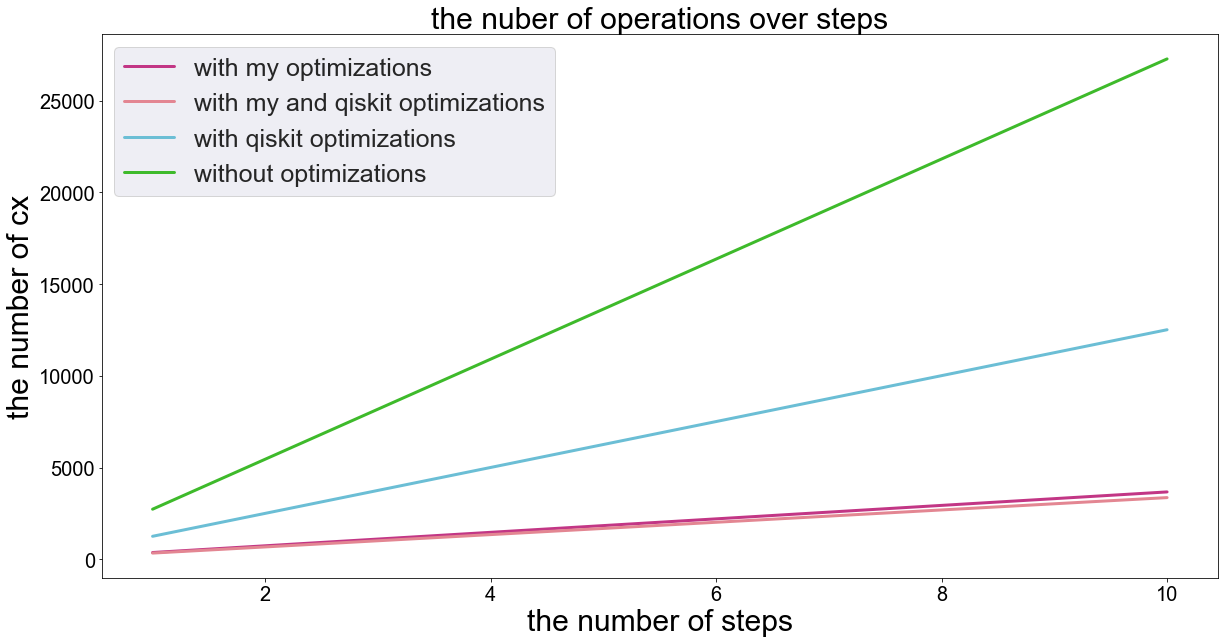

In [18]:
cx = [ex1_cx, ex2_cx, ex3_cx, ex4_cx]
u3 = [ex1_u3, ex2_u3, ex3_u3, ex4_u3]
color = ['#C23685',  '#E38692', '#6BBED5', '#3EBA2B']
labels = ['with my optimizations', 'with my and qiskit optimizations', 'with qiskit optimizations', 'without optimizations']
steps = range(1, 11)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111)
sns.set()
plt.xlabel('the number of steps', fontsize=30)
plt.ylabel('the number of cx', fontsize=30)
plt.title('the nuber of operations over steps', fontsize=30)
plt.tick_params(labelsize=20)
for cs, col, lab in zip(cx, color, labels):
    plt.plot(steps, cs, color=col, label=lab, linewidth=3)
plt.legend(fontsize=25)

In [19]:
ex1_mean = []
ex1_std = []

ex2_mean = []
ex2_std = []

ex3_mean = []
ex3_std = []

ex4_mean = []
ex4_std = []
extime = 1

u3_error = depolarizing_error(0, 1)
qw_step = range(1, 11)
gate_error = np.arange(0, 0.1, 0.01)
# errors, steps= np.meshgrid(gate_error, qw_step)

bins = [format(i, '03b') for i in range(2**3)]
step = 1
opt_qc = eight_node(True, step, init_state_eight)
job = execute(opt_qc, backend=qasm_sim, shots=100000)
count = job.result().get_counts(opt_qc)
ideal_prob = [count.get(i, 0)/100000 for i in bins]
for ce in gate_error:
# noise model
    error_model = NoiseModel()
    cx_error = depolarizing_error(cxerr, 2)
    error_model.add_all_qubit_quantum_error(u3_error, ['u3', 'u2'])
    error_model.add_all_qubit_quantum_error(cx_error, ['cx'])
# ex1
    opt_qc = [transpile(eight_node(True, step, init_state_eight), basis_gates=['cx', 'u3'], optimization_level=0) for i in range(extime)]
    errors = get_error(opt_qc, ideal_prob, error_model, 3)
    ex1_mean.append(np.mean(errors))i
    ex1_std.append(np.std(errors))

#     ex2
    opt_qc = [transpile(eight_node(True, step, init_state_eight), basis_gates=['cx', 'u3'], optimization_level=3) for i in range(extime)]
    errors = get_error(opt_qc, ideal_prob, error_model, 3)
    ex2_mean.append(np.mean(errors))
    ex2_std.append(np.std(errors))

# ex3
    opt_qc = [transpile(eight_node(False, step, init_state_eight), basis_gates=['cx', 'u3'], optimization_level=3)for i in range(extime)]
    errors = get_error(opt_qc, ideal_prob, error_model, 3)
    ex3_mean.append(np.mean(errors))
    ex3_std.append(np.std(errors))

#     ex4
    nopt_qc = [transpile(eight_node(False, step, init_state_eight), basis_gates=['cx', 'u3'], optimization_level=0) for i in range(extime)]
    errors = get_error(nopt_qc, ideal_prob, error_model, 3)
    ex4_mean.append(np.mean(errors))
    ex4_std.append(np.std(errors))

10it [13:30:07, 4860.71s/it]


In [ ]:
# 1step

fig = plt.figure(figsize=(20, 10))
plt.plot(gate_error, ex1_mean, label='ex1')
plt.plot(gate_error, ex2_mean, label='ex2')
plt.plot(gate_error, ex3_mean, label='ex3')
plt.plot(gate_error, ex4_mean, label='ex4')

plt.tick_params(labelsize=20)
plt.legend(fontsize=20)
plt.show()

In [ ]:
# res1 = np.array(ex1_mean).reshape(10, 10)
# res2 = np.array(ex2_mean).reshape(10, 10)
# res3 = np.array(ex3_mean).reshape(10, 10)
# res4 = np.array(ex4_mean).reshape(10, 10)

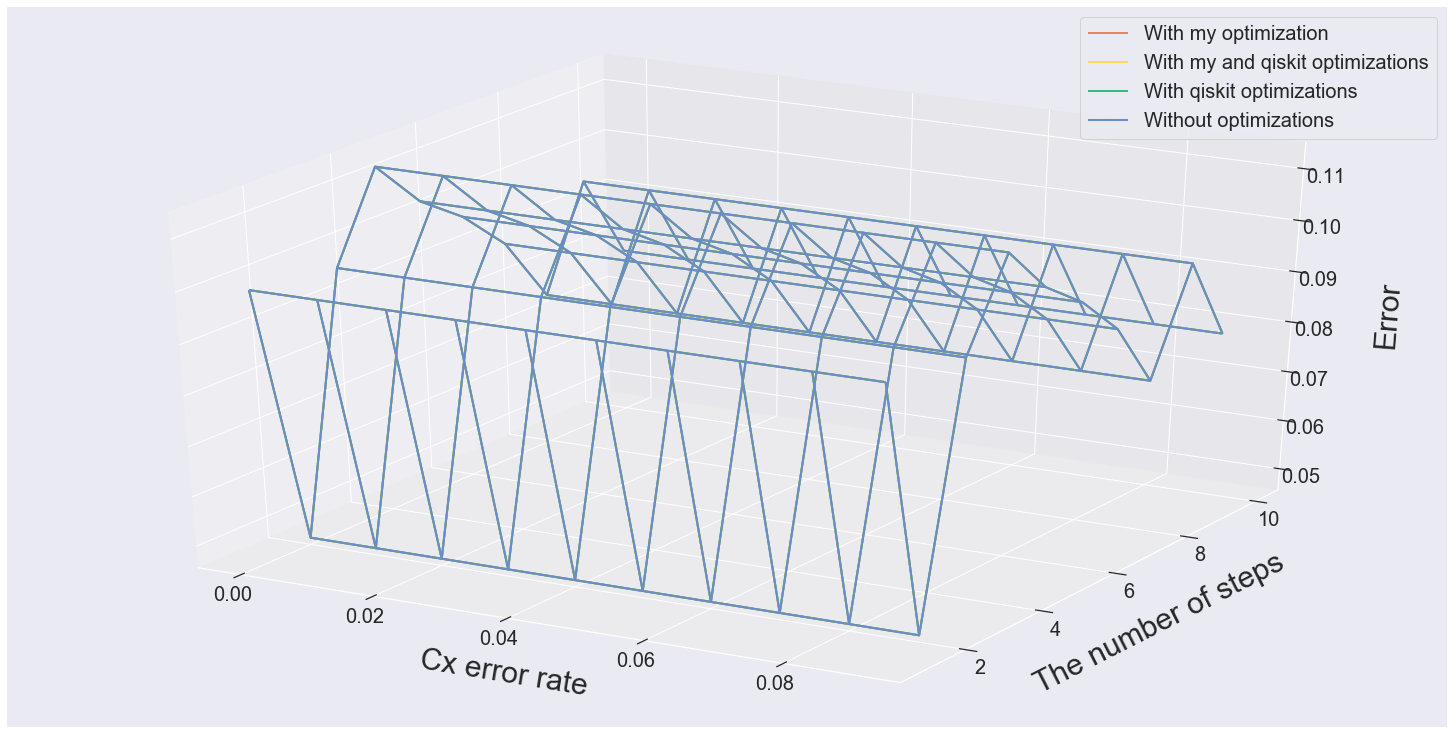

In [22]:
# fig = plt.figure(figsize=(20, 10))
# ax = Axes3D(fig)

# ax.plot_wireframe(errors, steps, res1, color='#E6855E', linewidth=2, label='With my optimization')
# ax.plot_wireframe(errors, steps, res2, color='#F9DB57', linewidth=2, label='With my and qiskit optimizations')
# ax.plot_wireframe(errors, steps, res3, color='#3DB680', linewidth=2, label='With qiskit optimizations')
# ax.plot_wireframe(errors, steps, res4, color='#6A8CC7', linewidth=2, label='Without optimizations')

# ax.set_xlabel('Cx error rate', labelpad=30, fontsize=30)
# ax.set_ylabel('The number of steps', labelpad=30, fontsize=30)
# ax.set_zlabel('Error', labelpad=30, fontsize=30)
# plt.tick_params(labelsize=20)
# plt.legend(fontsize=20)
# plt.show()

## 3. Multi step of 8 node graph with multi partition

In [41]:
alpha = 0.85
target_graph = np.array([[0, 0, 0, 1, 1, 0, 0, 0],
                                [1, 0, 0, 0, 1, 0, 0, 0],
                                [0, 1, 0, 0, 0, 1, 0, 0],
                               [0, 0, 1, 0, 0, 1, 0, 0],
                               [0, 0, 0, 0, 0, 0, 1, 1],
                               [0, 0, 0, 0, 0, 0, 1, 1],
                               [0, 0, 0, 0, 0, 0, 1, 1],
                               [0, 0, 0, 0, 0, 0, 1, 1]])


E = np.array([[0, 0, 0, 1, 1/2, 0, 0, 0],
                 [1, 0, 0, 0, 1/2, 0, 0, 0],
                 [0, 1, 0, 0, 0, 1/2, 0, 0],
                 [0, 0, 1, 0, 0, 1/2, 0, 0],
                 [0, 0, 0, 0, 0, 0, 1/4, 1/4],
                 [0, 0, 0, 0, 0, 0, 1/4, 1/4],
                 [0, 0, 0, 0, 0, 0, 1/4, 1/4],
                 [0, 0, 0, 0, 0, 0, 1/4, 1/4]])
# use google matrix
prob_dist = alpha*E + ((1-alpha)/8)*np.ones((8, 8))
init_state = 1/np.sqrt(8)*np.array([np.sqrt(prob_dist[j][i]) for i in range(8) for j in range(8)])

In [20]:
def mch(qc, controls, target, anc, tganc):
#     multi control hadamard gate
    if len(controls) == 1:
        qc.ch(*controls, target)
    elif len(controls) == 2:
        qc.ccx(controls[0], controls[1], tganc[0])
        qc.ch(tganc[0], target)
        qc.ccx(controls[0], controls[1], tganc[0])
    elif len(controls) > 2:
        qc.mct(controls, tganc[0], anc)
        for tg in target:
            qc.ch(tganc[0], tg)
        qc.mct(controls, tganc[0], anc)
    return qc

In [21]:
# Circuit
def eight_node_multi(opt, step, initial, hardopt=False):
    rotation11 = np.radians(31.788)
    rotation12 = np.radians(23.231)
    rotation13 = np.radians(163.285)
    
    rotation21 = np.radians(31.788)
    rotation22 = np.radians(23.231)
    
    rotation31 = np.radians(148.212)
    
#     for multi qubit hadamrd gate
    hs = QuantumCircuit.ch
    
    
    cq = QuantumRegister(3, 'control')
    tq = QuantumRegister(3, 'target')
#     ancilla for mct gates
    anc = QuantumRegister(3, 'mct anc')
    tganc = QuantumRegister(1, 'tgancila')
    c = ClassicalRegister(3, 'classical')
    if opt:
        opt_anc = QuantumRegister(2, 'ancilla')
        qc = QuantumCircuit(cq, tq, anc, opt_anc, tganc,  c)
    else:
        qc = QuantumCircuit(cq, tq, anc,tganc, c)
        
#     initialize with probability distribution matrix
    if initial is not None:
        qc.initialize(initial, [*cq, *tq])
    
    for t in range(step):
        # Ti operation(opt)
        # T11
        qc.x(cq[1])
        qc.mct([cq[1], cq[2]], tq[1], anc)
        qc.x(cq[1])
        qc.barrier()
        
        # T12
        qc.x(cq[0])
        qc.x(cq[2])
        qc.mct(cq, tq[1], anc)
        qc.x(cq[0])
        qc.x(cq[2])
        qc.barrier()
        
        # T21
        qc.x(cq[0])
        qc.mct([cq[0], cq[2]], tq[2], anc)
        qc.x(cq[0])
        qc.barrier()

#         # Kdg operation
        if opt:
            if hardopt:
                raise Exception('under const')
            else:
                # K1dg
                qc.x(cq[0]) # s1
                qc.x(tq[0]) # s2
                
                mch(qc, [cq[0], tq[0], tq[1]], [tq[2]], anc, tganc)
                
                qc.x(tq[1]) # s3
                qc.mcry(-rotation13, [cq[0], tq[0], tq[1]], tq[2],  anc)
                qc.x(tq[1]) # e3
                qc.x(tq[0]) # e2
                
                mch(qc, [cq[0],  tq[0]], [tq[1], tq[2]], anc, tganc)
                
                qc.x(tq[0]) # s4
                qc.mcry(-rotation12, [cq[0], tq[0]], tq[1], anc)
                qc.x(tq[0]) # e4
                qc.cry(-rotation11, cq[0], tq[0])
                qc.x(cq[0]) # e1
                qc.barrier
                # K2dg
                # map
                qc.x(cq[1])
                qc.ccx(cq[0], cq[1], opt_anc[0])
                qc.x(cq[1])
                # op
                qc.ch(opt_anc[0], tq[2])
                qc.ry(pi/4, tq[1])
                qc.ccx(opt_anc[0], tq[0], tq[1])
                qc.ry(-pi/4, tq[1])
                qc.x(tq[0])# s1
                qc.mcry(-rotation22, [opt_anc[0], tq[0]], tq[1], anc)
                qc.x(tq[0]) # e1
                qc.cry(-rotation21, opt_anc[0], tq[0])
                qc.barrier
                # K3dg
                #map
                qc.ccx(cq[0], cq[1], opt_anc[1])
                # op
                qc.ch(opt_anc[1], tq[2])
                qc.ch(opt_anc[1], tq[1])
                qc.cry(-rotation31, opt_anc[1], tq[0])
                qc.barrier
                
        else:
            # K1dg
            qc.x(cq[0]) # s1
            qc.x(tq[0])  # s2
            
            mch(qc, [cq[0], tq[0], tq[1]], [tq[2]], anc, tganc)
            
            qc.x(tq[1]) # s3
            qc.mcry(-rotation13, [cq[0], tq[0], tq[1]], tq[2], anc) # rotation 3 dg
            qc.x(tq[1]) # e3
            qc.x(tq[0]) # e2
            
            mch(qc, [cq[0], tq[0]], [tq[1], tq[2]], anc, tganc)
            
            qc.x(tq[0]) # s4
            qc.mcry(-rotation12, [cq[0], tq[0]], tq[1],  anc)
            qc.x(tq[0]) # e4
            qc.cry(-rotation11, cq[0], tq[0])
            # K2dg
            qc.x(cq[1]) # s1
            qc.x(tq[0]) # s2
            
            mch(qc, [cq[0], cq[1], tq[0]], [tq[2]], anc, tganc)
            
            qc.x(tq[0]) # e2
            
            mch(qc, [cq[0], cq[1], tq[0]], [tq[1], tq[2]], anc, tganc)
            
            qc.x(tq[0]) # s3
            qc.mcry(-rotation22, [cq[0], cq[1], tq[0]], tq[1], anc)
            qc.x(tq[0]) # e3
            qc.mcry(-rotation21, [cq[0], cq[1]], tq[0], anc)
            # K3dg
            
            mch(qc, [cq[0], cq[1]], [tq[1], tq[2]], anc, tganc)
            
            qc.mcry(-rotation31, [cq[0], cq[1]], tq[0], anc)

        # D operation
        qc.x(tq)
        qc.h(tq[2])
        qc.ccx(tq[0], tq[1], tq[2])
        qc.h(tq[2])
        qc.x(tq)
        qc.barrier()

#         # K operation
        if opt:
            if hardopt:
                raise Exception('under')
            else:
                # K3
                qc.cry(rotation31, opt_anc[1], tq[0])
                qc.ch(opt_anc[1], tq[1])
                qc.ch(opt_anc[1], tq[2])
                #unmap
                qc.ccx(cq[1], cq[0], opt_anc[1])
                qc.barrier
                # K2
                qc.cry(rotation21, opt_anc[0], tq[0])
                qc.x(tq[0]) # s1
                qc.mcry(rotation22, [opt_anc[0], tq[0]], tq[1], anc)
                qc.x(tq[0])
                qc.ry(pi/4, tq[1])
                qc.ccx(opt_anc[0], tq[0], tq[1])
                qc.ry(-pi/4, tq[1])
                qc.ch(opt_anc[0], tq[2])
                # unmap
                qc.x(cq[1])
                qc.ccx(cq[1], cq[0], opt_anc[0])
                qc.x(cq[1])
                # op
                qc.barrier
                # K1
                qc.x(cq[0]) # s1
                qc.cry(rotation11, cq[0], tq[0])
                qc.x(tq[0]) # s2
                qc.mcry(rotation12, [cq[0], tq[0]], tq[1], anc)
                qc.x(tq[0]) # e2
                
                mch(qc, [cq[0], tq[0]],  [tq[1], tq[2]], anc, tganc)
                
                qc.x(tq[0]) #s3
                qc.x(tq[1]) # s4
                qc.mcry(rotation13, [cq[0], tq[0], tq[1]], tq[2], anc)
                qc.x(tq[1]) # 4
                
                mch(qc, [cq[0], tq[0], tq[1]], [tq[2]], anc, tganc)
                
                qc.x(tq[0]) # e3
                qc.x(cq[0]) # e1
                qc.barrier
        else:
            # K3
            qc.mcry(rotation31, [cq[0], cq[1]], tq[0], anc)
            
            mch(qc, [cq[0], cq[1]], [tq[1]], anc, tganc)
            mch(qc, [cq[0], cq[1]], [tq[2]], anc, tganc)
            
            # K2
            qc.mcry(rotation21, [cq[0], cq[1]], tq[0], anc)
            qc.x(tq[0]) # e3
            qc.mcry(rotation22, [cq[0], cq[1], tq[0]], tq[1], anc)
            qc.x(tq[0]) # s3
            
            mch(qc, [cq[0], cq[1], tq[0]], [tq[1]], anc, tganc)
            mch(qc, [cq[0], cq[1], tq[0]], [tq[2]], anc, tganc)
            
            qc.x(tq[0]) # e2
            
            mch(qc, [cq[0], cq[1], tq[0]], [tq[2]], anc, tganc)
            
            qc.x(tq[0]) # s2
            qc.x(cq[1]) # s1
            # K1
            qc.cry(rotation11, cq[0], tq[0])
            qc.x(tq[0]) # e4
            qc.mcry(rotation12, [cq[0], tq[0]], tq[1], anc)
            qc.x(tq[0]) # s4
            
            mch(qc, [cq[0], tq[0]], [tq[2]], anc, tganc)
            mch(qc, [cq[0], tq[0]], [tq[2]], anc, tganc)
            
            qc.x(tq[0]) # e2
            qc.x(tq[1]) # e3
            qc.mcry(rotation13, [cq[0], tq[0], tq[1]], tq[2], anc) # rotation 3 dg
            qc.x(tq[1]) # s3
            
            mch(qc, [cq[0], tq[0], tq[1]], [tq[2]], anc, tganc) 
            
            qc.x(tq[0])  # s2
            qc.x(cq[0]) # s1
        
        # T21 dg
        qc.x(cq[0])
        qc.mct([cq[0], cq[2]], tq[2], anc)
        qc.x(cq[0])
        qc.barrier()
        
        # T12dg
        qc.x(cq[0])
        qc.x(cq[2])
        qc.mct(cq, tq[1], anc)
        qc.x(cq[0])
        qc.x(cq[2])
        qc.barrier()
        
        # T11 dg
        qc.x(cq[1])
        qc.mct([cq[0], cq[1]], tq[1], anc)
        qc.x(cq[1])
        # swap
        for cont, targ in zip(cq, tq):
            qc.swap(cont, targ)
    qc.measure(cq, c)
    return qc

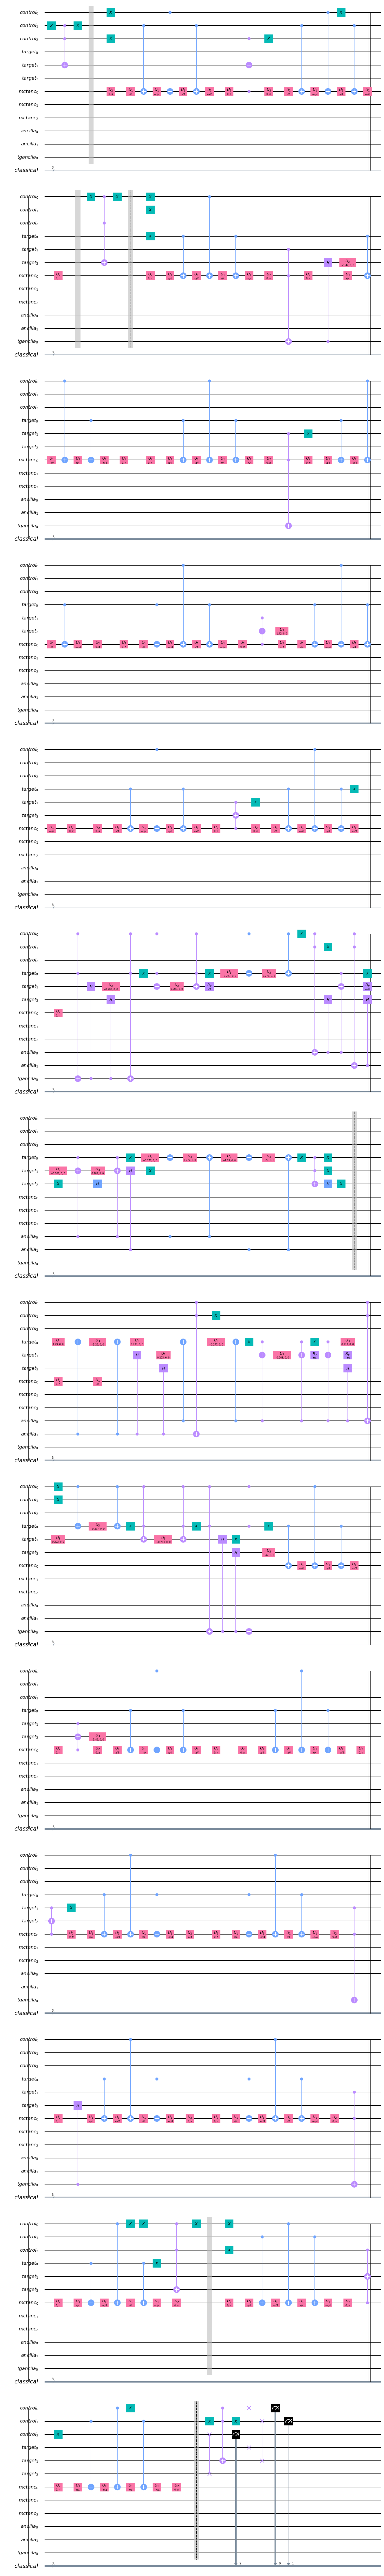

In [22]:
qc = eight_node_multi(True, 1, None)
qc.draw(output='mpl')

In [88]:
# circuit verifications
qasm_sim = Aer.get_backend('qasm_simulator')
init_state = [np.sqrt(1/64) for i in range(64)]
for step in range(1, 11):
    opt_qc1 = transpile(eight_node_multi(True, step, init_state), basis_gates=['cx', 'u3'], optimization_level=0)
    opt_qc2 = transpile(eight_node_multi(True, step, init_state), basis_gates=['cx', 'u3'], optimization_level=3)
    opt_qc3 = transpile(eight_node_multi(False, step, init_state), basis_gates=['cx', 'u3'], optimization_level=3)
    nopt_qc = transpile(eight_node_multi(False, step, init_state), basis_gates=['cx', 'u3'], optimization_level=0)
    job1 = execute(opt_qc1, backend=qasm_sim, shots=10000)
    job2 = execute(opt_qc2, backend=qasm_sim, shots=10000)
    job3 = execute(opt_qc3, backend=qasm_sim, shots=10000)
    job4 = execute(nopt_qc, backend=qasm_sim, shots=10000)

    count1 = job1.result().get_counts()
    count2 = job2.result().get_counts()
    count3 = job3.result().get_counts()
    count4 = job4.result().get_counts()
    print(count1.get('000'), count2.get('000'), count3.get('000'), count4.get('000'))

956 947 1213 1215


KeyboardInterrupt: 

Play ground

In [33]:
q = QuantumRegister(1)
qc = QuantumCircuit(q)
rotation12 = np.radians(23.231)
qc.u3(pi/2+rotation12, 0, pi, q[0])
unit = Aer.get_backend('unitary_simulator')
job = execute(qc, backend=unit)
uni = job.result().get_unitary()
print(uni)

[[ 0.55 +0.000e+00j  0.835-1.023e-16j]
 [ 0.835+0.000e+00j -0.55 +6.739e-17j]]


In [34]:
q = QuantumRegister(1)
qc = QuantumCircuit(q)
rotation12 = np.radians(23.231)
qc.u3(pi/2, 0, pi, q[0])
qc.ry(rotation12, q[0])
unit = Aer.get_backend('unitary_simulator')
job = execute(qc, backend=unit)
uni = job.result().get_unitary()
print(uni)

[[ 0.55 +0.000e+00j  0.835-1.023e-16j]
 [ 0.835+0.000e+00j -0.55 +6.739e-17j]]


In [73]:
q = QuantumRegister(3,'qr')
anc = QuantumRegister(2, 'anc')
qc = QuantumCircuit(q, anc)
qc.mcmt([q[0], q[1]], anc, QuantumCircuit.ch, [q[2]])

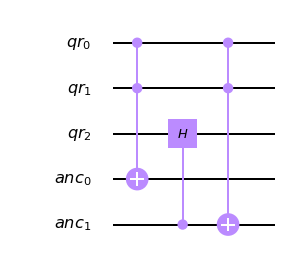

In [74]:
qc.draw(output='mpl')

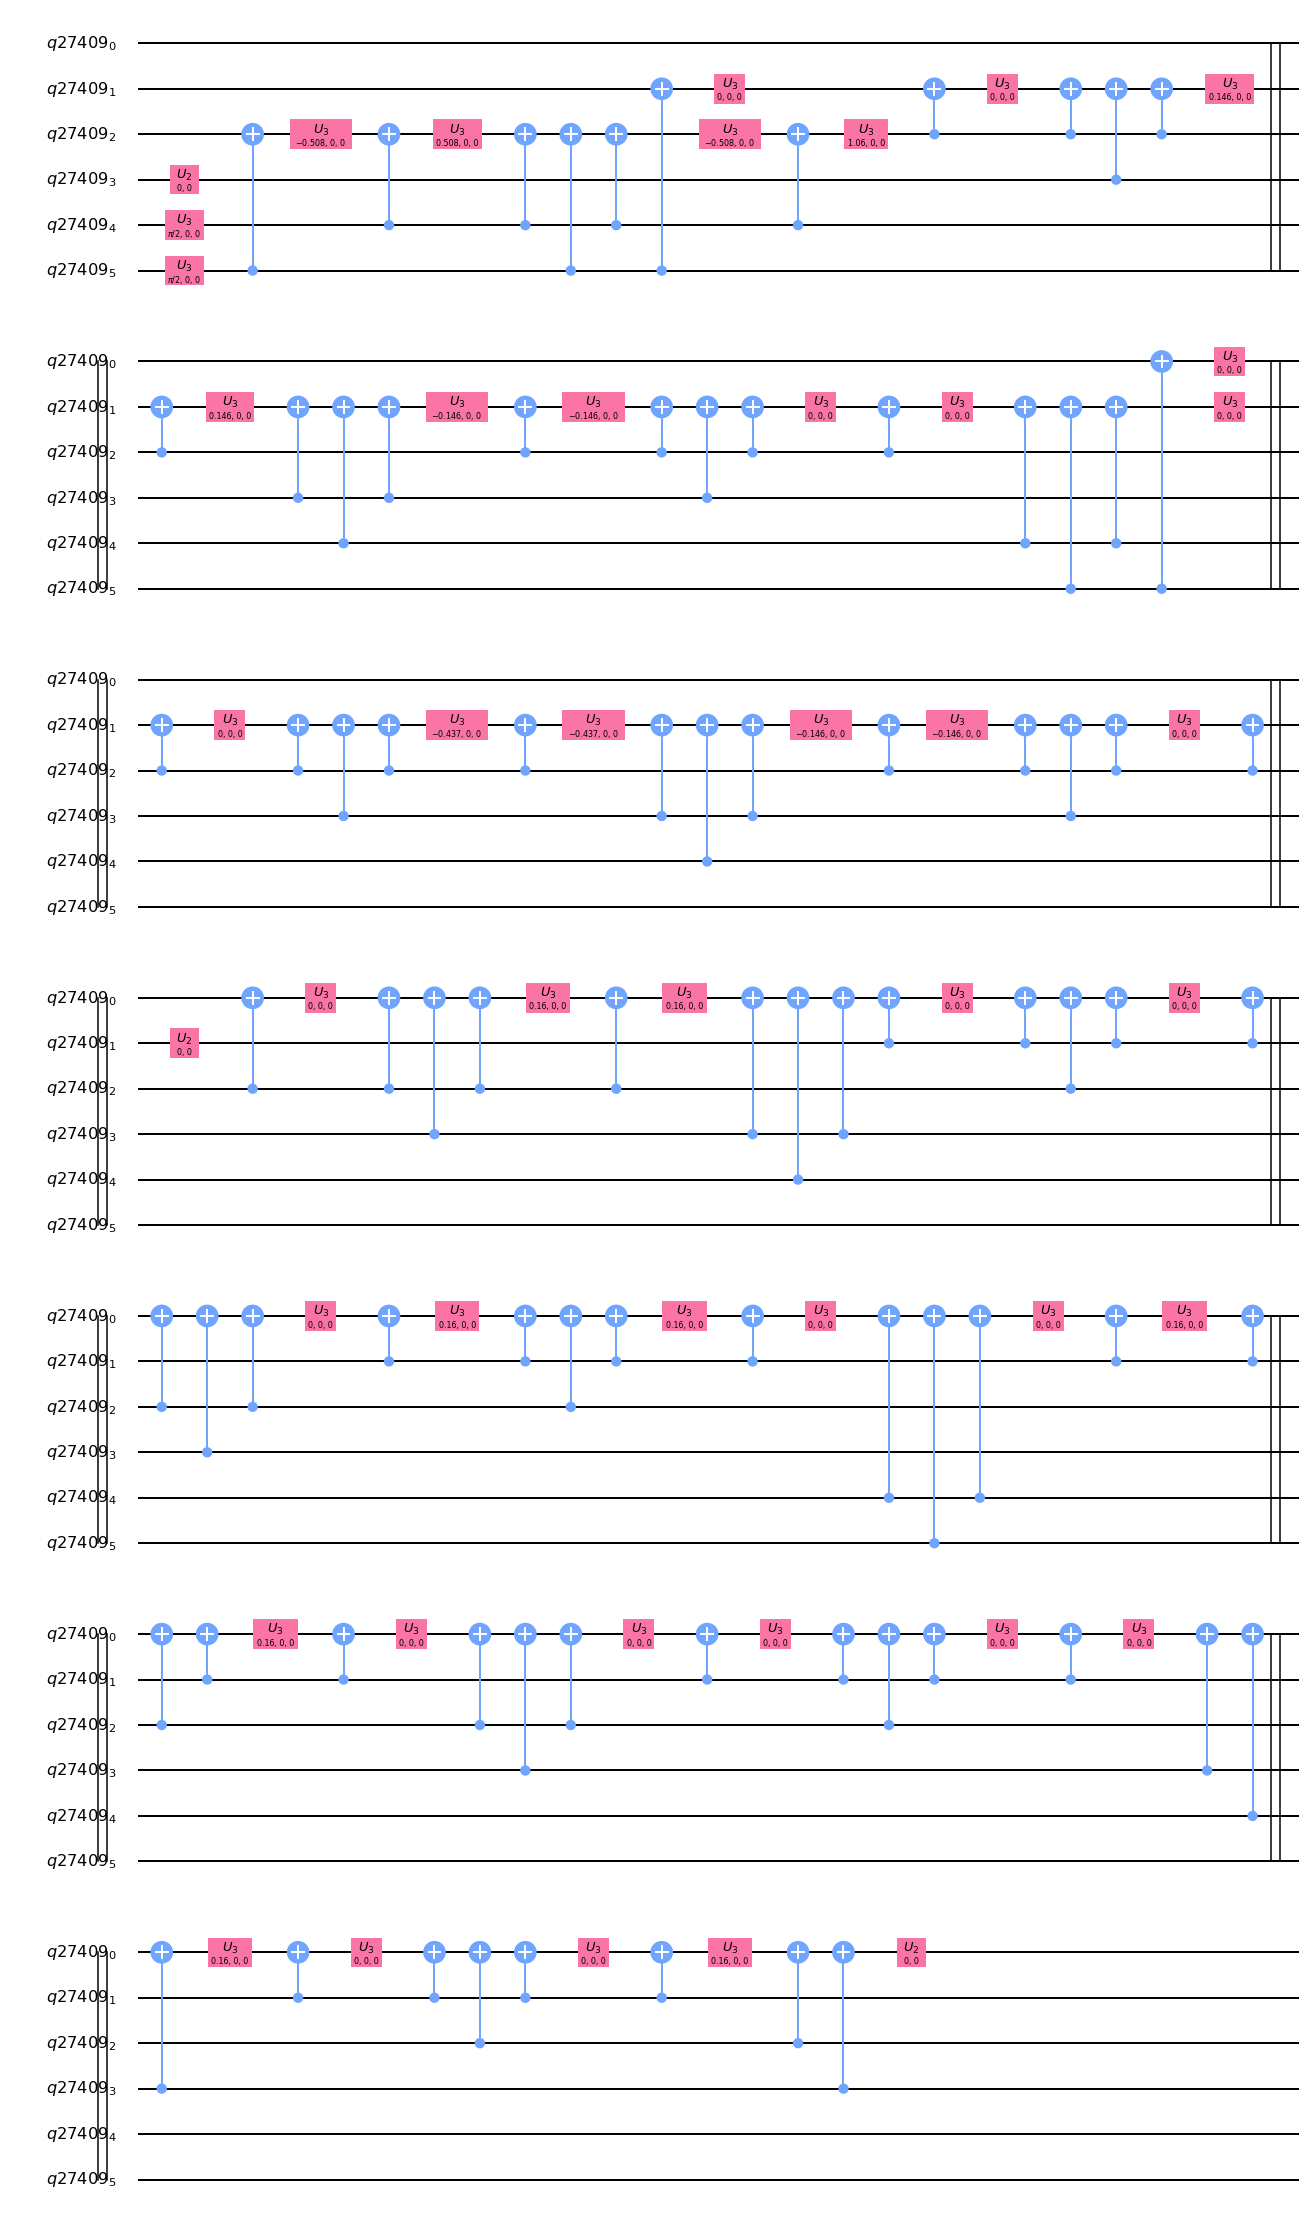

In [81]:
q = QuantumRegister(6)
qc = QuantumCircuit(q)
qc.initialize(init_state, q)
nqc = transpile(qc, basis_gates=['cx', 'h', 'x', 'u3'])
nqc.draw(output='mpl')

## 4. Multi step of 1024 node graph with multi partition